Made with help of chatgpt and github copilot by feeding question subparts as prompt

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
vgg19 = models.vgg19(pretrained=True).features
vgg19.eval()

for param in vgg19.parameters():
    param.requires_grad_(False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg19.to(device)

c:\Users\SHARS\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\SHARS\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [3]:
content_layers = ['21']
style_layers = ['0', '5', '10', '19', '28']

In [4]:
def get_features(image, model, layers):
    extracted = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            extracted[name] = x
    return extracted

In [5]:
def calculate_content_loss(content_features, generated_features):
    return F.mse_loss(content_features, generated_features)

def calculate_style_loss(style_features, generated_features):
    batch_size, C, H, W = style_features.shape
    F_style = style_features.view(C, H * W)
    F_gen = generated_features.view(C, H * W)
    G_style = torch.mm(F_style, F_style.t())
    G_gen = torch.mm(F_gen, F_gen.t())
    
    normalization_factor = 4 * (C * 2) * (H * W) * 2
    return F.mse_loss(G_style, G_gen) / normalization_factor

In [6]:
def load_image(image_path, max_size=512):
    image = Image.open(image_path).convert('RGB')
    size = min(max_size, max(image.size))
    transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = transform(image).unsqueeze(0)
    return image.to(device)

In [21]:
def run_style_transfer(content_image, style_image, num_steps=300, content_weight=1, style_weight=1e4):
    generated_image = content_image.clone().requires_grad_(True)
    optimizer = optim.LBFGS([generated_image], lr=0.1)

    step = [0]  

    def closure():
        optimizer.zero_grad()
        content_features = get_features(content_image, vgg19, content_layers)
        style_features = get_features(style_image, vgg19, style_layers)
        gen_features = get_features(generated_image, vgg19, content_layers + style_layers)

        content_loss = sum(
            calculate_content_loss(content_features[layer], gen_features[layer])
            for layer in content_layers
        )

        style_loss = sum(
            calculate_style_loss(style_features[layer], gen_features[layer])
            for layer in style_layers
        )

        total_loss = content_weight * content_loss + style_weight * style_loss
        total_loss.backward()

        if step[0] % 50 == 0:
            print(f"Step {step[0]}: Content Loss = {content_loss.item():.4f}, Style Loss = {style_loss.item():.4f}")

        step[0] += 1
        return total_loss

    for _ in range(num_steps):
        optimizer.step(closure)

    return generated_image

In [8]:
content_image = load_image('content/mountains.jpg')
style_image = load_image('styles/the-exit-of-the-russian-ballet.jpg')

content_size = (content_image.size(2), content_image.size(3))
style_image = F.interpolate(
    style_image,
    size=content_size,
    mode='bilinear',
    align_corners=False,
    antialias=True
)

Step 0: Content Loss = 0.0000, Style Loss = 86.3878
Step 50: Content Loss = 4.2020, Style Loss = 30.9815
Step 100: Content Loss = 6.2197, Style Loss = 12.4033
Step 150: Content Loss = 7.2209, Style Loss = 5.2740
Step 200: Content Loss = 7.8657, Style Loss = 2.5558
Step 250: Content Loss = 8.3046, Style Loss = 1.4662
Step 300: Content Loss = 8.5987, Style Loss = 0.9284
Step 350: Content Loss = 8.8665, Style Loss = 0.6008
Step 400: Content Loss = 9.1157, Style Loss = 0.3970
Step 450: Content Loss = 9.2959, Style Loss = 0.2690
Step 500: Content Loss = 9.4543, Style Loss = 0.1916
Step 550: Content Loss = 9.5683, Style Loss = 0.1423
Step 600: Content Loss = 9.6670, Style Loss = 0.1090
Step 650: Content Loss = 9.7319, Style Loss = 0.0856
Step 700: Content Loss = 9.7800, Style Loss = 0.0691
Step 750: Content Loss = 9.8201, Style Loss = 0.0574
Step 800: Content Loss = 9.8546, Style Loss = 0.0488
Step 850: Content Loss = 9.8837, Style Loss = 0.0424
Step 900: Content Loss = 9.9066, Style Loss = 

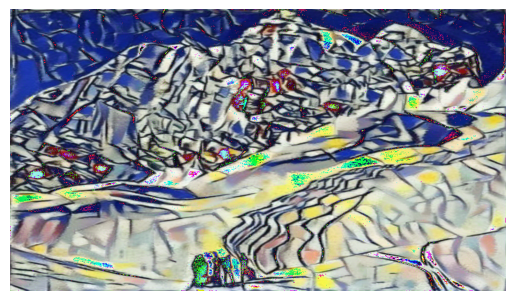

In [9]:
output_image = run_style_transfer(
    content_image,
    style_image,
    num_steps=50,
    content_weight=1,
    style_weight=1e4
)

def postprocess_image(tensor):
    tensor = tensor.cpu().clone().squeeze(0)
    transform = transforms.Compose([
        transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225], std=[1/0.229, 1/0.224, 1/0.225]),
        transforms.ToPILImage()
    ])
    return transform(tensor)

output_image = postprocess_image(output_image)
output_image.save("output.jpg")
plt.imshow(output_image)
plt.axis('off')
plt.show()

content_weight = 1
style_weight = 1e4

Step 0: Content Loss = 0.0000, Style Loss = 86.3878
Step 50: Content Loss = 4.2002, Style Loss = 30.9930
Step 100: Content Loss = 6.2244, Style Loss = 12.3636
Step 150: Content Loss = 7.2235, Style Loss = 5.2691
Step 200: Content Loss = 7.8632, Style Loss = 2.5600
Step 250: Content Loss = 8.2886, Style Loss = 1.4694
Step 300: Content Loss = 8.5959, Style Loss = 0.9295
Step 350: Content Loss = 8.8722, Style Loss = 0.6003
Step 400: Content Loss = 9.1136, Style Loss = 0.3959
Step 450: Content Loss = 9.3162, Style Loss = 0.2681
Step 500: Content Loss = 9.4696, Style Loss = 0.1901
Step 550: Content Loss = 9.5969, Style Loss = 0.1418
Step 600: Content Loss = 9.6940, Style Loss = 0.1092
Step 650: Content Loss = 9.7713, Style Loss = 0.0860
Step 700: Content Loss = 9.8233, Style Loss = 0.0694
Step 750: Content Loss = 9.8704, Style Loss = 0.0576
Step 800: Content Loss = 9.9065, Style Loss = 0.0490
Step 850: Content Loss = 9.9367, Style Loss = 0.0424
Step 900: Content Loss = 9.9614, Style Loss = 

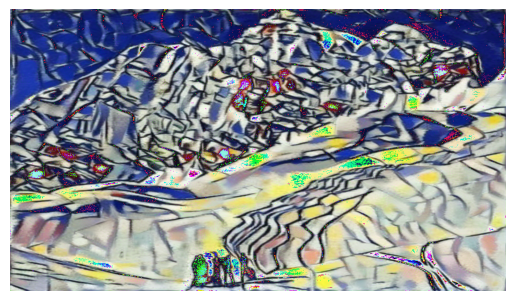

In [10]:
output_image = run_style_transfer(
    content_image,
    style_image,
    num_steps=50,
    content_weight=2,
    style_weight=1e5
)

def postprocess_image(tensor):
    tensor = tensor.cpu().clone().squeeze(0)
    transform = transforms.Compose([
        transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225], std=[1/0.229, 1/0.224, 1/0.225]),
        transforms.ToPILImage()
    ])
    return transform(tensor)

output_image = postprocess_image(output_image)
output_image.save("output.jpg")
plt.imshow(output_image)
plt.axis('off')
plt.show()

content_weight - 2, style weight 1e5

Step 0: Content Loss = 0.0000, Style Loss = 86.3878
Step 50: Content Loss = 4.2046, Style Loss = 30.9563
Step 100: Content Loss = 6.2234, Style Loss = 12.3747
Step 150: Content Loss = 7.2194, Style Loss = 5.2746
Step 200: Content Loss = 7.8658, Style Loss = 2.5615
Step 250: Content Loss = 8.3045, Style Loss = 1.4696
Step 300: Content Loss = 8.6017, Style Loss = 0.9300
Step 350: Content Loss = 8.8834, Style Loss = 0.6007
Step 400: Content Loss = 9.1243, Style Loss = 0.3969
Step 450: Content Loss = 9.3074, Style Loss = 0.2693
Step 500: Content Loss = 9.4681, Style Loss = 0.1913
Step 550: Content Loss = 9.5863, Style Loss = 0.1424
Step 600: Content Loss = 9.6846, Style Loss = 0.1092
Step 650: Content Loss = 9.7593, Style Loss = 0.0857
Step 700: Content Loss = 9.8204, Style Loss = 0.0693
Step 750: Content Loss = 9.8635, Style Loss = 0.0576
Step 800: Content Loss = 9.8981, Style Loss = 0.0488
Step 850: Content Loss = 9.9312, Style Loss = 0.0424
Step 900: Content Loss = 9.9607, Style Loss = 

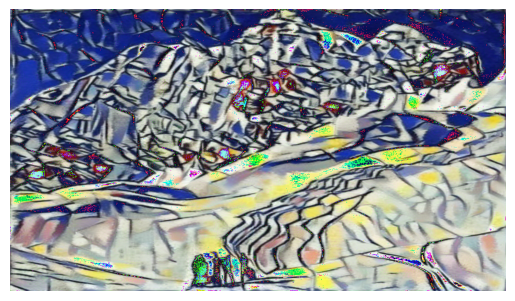

In [11]:
output_image = run_style_transfer(
    content_image,
    style_image,
    num_steps=50,
    content_weight=10,
    style_weight=1e6
)

def postprocess_image(tensor):
    tensor = tensor.cpu().clone().squeeze(0)
    transform = transforms.Compose([
        transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225], std=[1/0.229, 1/0.224, 1/0.225]),
        transforms.ToPILImage()
    ])
    return transform(tensor)

output_image = postprocess_image(output_image)
output_image.save("output.jpg")
plt.imshow(output_image)
plt.axis('off')
plt.show()

content weight = 10 , style weight 1e6

Step 0: Content Loss = 0.0000, Style Loss = 86.3878
Step 50: Content Loss = 4.2009, Style Loss = 30.9831
Step 100: Content Loss = 6.2249, Style Loss = 12.3704
Step 150: Content Loss = 7.2259, Style Loss = 5.2708
Step 200: Content Loss = 7.8578, Style Loss = 2.5647
Step 250: Content Loss = 8.2893, Style Loss = 1.4685
Step 300: Content Loss = 8.5958, Style Loss = 0.9291
Step 350: Content Loss = 8.8639, Style Loss = 0.6013
Step 400: Content Loss = 9.1034, Style Loss = 0.3973
Step 450: Content Loss = 9.3243, Style Loss = 0.2690
Step 500: Content Loss = 9.4889, Style Loss = 0.1915
Step 550: Content Loss = 9.5996, Style Loss = 0.1427
Step 600: Content Loss = 9.6886, Style Loss = 0.1095
Step 650: Content Loss = 9.7673, Style Loss = 0.0857
Step 700: Content Loss = 9.8248, Style Loss = 0.0693
Step 750: Content Loss = 9.8726, Style Loss = 0.0573
Step 800: Content Loss = 9.9012, Style Loss = 0.0487
Step 850: Content Loss = 9.9277, Style Loss = 0.0423
Step 900: Content Loss = 9.9543, Style Loss = 

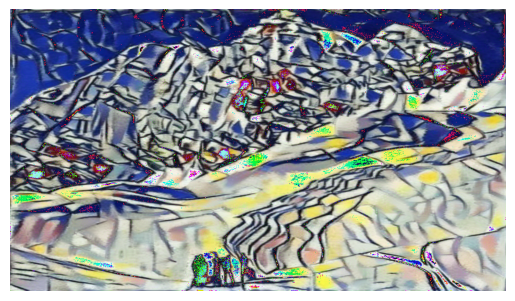

In [12]:
output_image = run_style_transfer(
    content_image,
    style_image,
    num_steps=50,
    content_weight=0.1,
    style_weight=1e7
)

def postprocess_image(tensor):
    tensor = tensor.cpu().clone().squeeze(0)
    transform = transforms.Compose([
        transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225], std=[1/0.229, 1/0.224, 1/0.225]),
        transforms.ToPILImage()
    ])
    return transform(tensor)

output_image = postprocess_image(output_image)
output_image.save("output.jpg")
plt.imshow(output_image)
plt.axis('off')
plt.show()

content_weight - 0.1, style weight = 1e7

Step 0: Content Loss = 0.0000, Style Loss = 86.3878
Step 50: Content Loss = 3.9487, Style Loss = 31.0086
Step 100: Content Loss = 5.6258, Style Loss = 12.3517
Step 150: Content Loss = 6.1856, Style Loss = 5.2693
Step 200: Content Loss = 6.2698, Style Loss = 2.6047
Step 250: Content Loss = 6.1170, Style Loss = 1.5481
Step 300: Content Loss = 5.8975, Style Loss = 1.0441
Step 350: Content Loss = 5.6742, Style Loss = 0.7416
Step 400: Content Loss = 5.4689, Style Loss = 0.5513
Step 450: Content Loss = 5.2680, Style Loss = 0.4321
Step 500: Content Loss = 5.0965, Style Loss = 0.3535
Step 550: Content Loss = 4.9518, Style Loss = 0.3019
Step 600: Content Loss = 4.8267, Style Loss = 0.2668
Step 650: Content Loss = 4.7207, Style Loss = 0.2412
Step 700: Content Loss = 4.6332, Style Loss = 0.2217
Step 750: Content Loss = 4.5627, Style Loss = 0.2061
Step 800: Content Loss = 4.5002, Style Loss = 0.1940
Step 850: Content Loss = 4.4500, Style Loss = 0.1844
Step 900: Content Loss = 4.4064, Style Loss = 

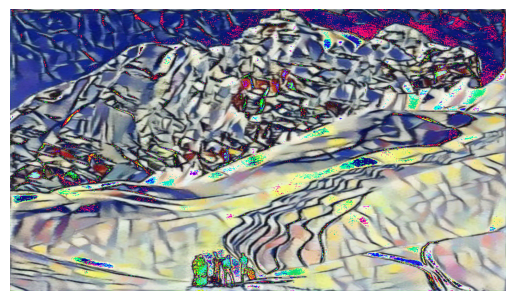

In [13]:
output_image = run_style_transfer(
    content_image,
    style_image,
    num_steps=50,
    content_weight=100,
    style_weight=1e3
)

def postprocess_image(tensor):
    tensor = tensor.cpu().clone().squeeze(0)
    transform = transforms.Compose([
        transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225], std=[1/0.229, 1/0.224, 1/0.225]),
        transforms.ToPILImage()
    ])
    return transform(tensor)

output_image = postprocess_image(output_image)
output_image.save("output.jpg")
plt.imshow(output_image)
plt.axis('off')
plt.show()

content_weight = 100 , style weight = 1e3

In [16]:
content_image = load_image('content/Self_Portrait.jpg')
style_image = load_image('styles/the-exit-of-the-russian-ballet.jpg')


content_size = (content_image.size(2), content_image.size(3))
style_image = F.interpolate(
    style_image,
    size=content_size,
    mode='bilinear',
    align_corners=False,
    antialias=True
)

Step 0: Content Loss = 0.0000, Style Loss = 168.6549
Step 50: Content Loss = 7.5969, Style Loss = 53.7325
Step 100: Content Loss = 9.9457, Style Loss = 18.5101
Step 150: Content Loss = 10.9072, Style Loss = 7.5253
Step 200: Content Loss = 11.5993, Style Loss = 3.8330
Step 250: Content Loss = 12.0161, Style Loss = 2.1415
Step 300: Content Loss = 12.4120, Style Loss = 1.2348
Step 350: Content Loss = 12.7226, Style Loss = 0.7405
Step 400: Content Loss = 12.9560, Style Loss = 0.4623
Step 450: Content Loss = 13.1208, Style Loss = 0.3098
Step 500: Content Loss = 13.2439, Style Loss = 0.2223
Step 550: Content Loss = 13.3593, Style Loss = 0.1674
Step 600: Content Loss = 13.4522, Style Loss = 0.1308
Step 650: Content Loss = 13.5197, Style Loss = 0.1056
Step 700: Content Loss = 13.5792, Style Loss = 0.0873
Step 750: Content Loss = 13.6435, Style Loss = 0.0734
Step 800: Content Loss = 13.6919, Style Loss = 0.0630
Step 850: Content Loss = 13.7335, Style Loss = 0.0547
Step 900: Content Loss = 13.76

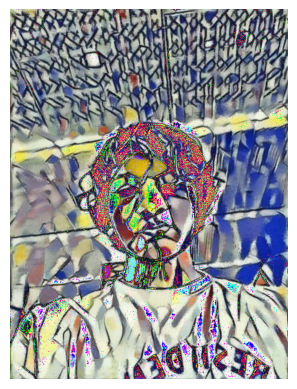

In [17]:
output_image = run_style_transfer(
    content_image,
    style_image,
    num_steps=50,
    content_weight=1,
    style_weight=1e4
)

def postprocess_image(tensor):
    tensor = tensor.cpu().clone().squeeze(0)
    transform = transforms.Compose([
        transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225], std=[1/0.229, 1/0.224, 1/0.225]),
        transforms.ToPILImage()
    ])
    return transform(tensor)

output_image = postprocess_image(output_image)
output_image.save("output.jpg")
plt.imshow(output_image)
plt.axis('off')
plt.show()

I went with the starting weight configs since it seemed to balance style and content loss effectively , and i see that the style transferred effectively in my self potrait

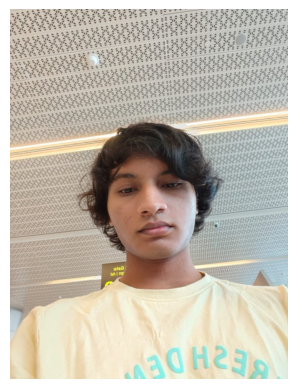

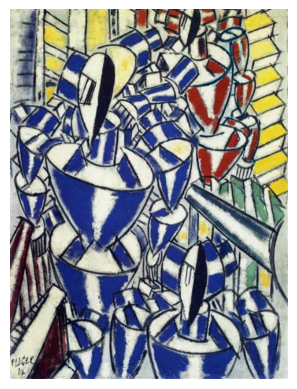

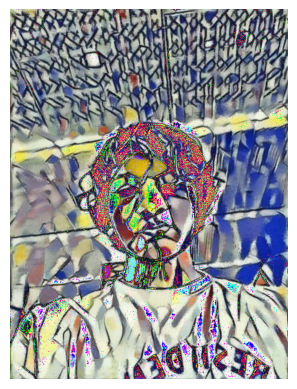

In [18]:
content_image = postprocess_image(content_image)
style_image = postprocess_image(style_image)
plt.imshow(content_image)
plt.axis('off')
plt.show()
plt.imshow(style_image)
plt.axis('off')
plt.show()
plt.imshow(output_image)
plt.axis('off')
plt.show()

now for comparision with adam optimiser

In [20]:
def run_style_transfer_adam(content_image, style_image, num_steps=300, content_weight=1, style_weight=1e4):
    generated_image = content_image.clone().requires_grad_(True)
    optimizer = optim.Adam([generated_image], lr=0.1)

    step = [0]  

    def closure():
        optimizer.zero_grad()
        content_features = get_features(content_image, vgg19, content_layers)
        style_features = get_features(style_image, vgg19, style_layers)
        gen_features = get_features(generated_image, vgg19, content_layers + style_layers)

        content_loss = sum(
            calculate_content_loss(content_features[layer], gen_features[layer])
            for layer in content_layers
        )

        style_loss = sum(
            calculate_style_loss(style_features[layer], gen_features[layer])
            for layer in style_layers
        )

        total_loss = content_weight * content_loss + style_weight * style_loss
        total_loss.backward()

        if step[0] % 50 == 0:
            print(f"Step {step[0]}: Content Loss = {content_loss.item():.4f}, Style Loss = {style_loss.item():.4f}")

        step[0] += 1
        return total_loss

    for _ in range(num_steps):
        optimizer.step(closure)

    return generated_image

Step 0: Content Loss = 0.0000, Style Loss = 86.3878
Step 0: Content Loss = 0.0000, Style Loss = 86.3878
Step 50: Content Loss = 4.2017, Style Loss = 30.9863
Step 100: Content Loss = 6.2249, Style Loss = 12.3810
Step 150: Content Loss = 7.2122, Style Loss = 5.2766
Step 200: Content Loss = 7.8488, Style Loss = 2.5649
Step 250: Content Loss = 8.2906, Style Loss = 1.4686
Step 300: Content Loss = 8.5959, Style Loss = 0.9302
Step 350: Content Loss = 8.8714, Style Loss = 0.6027
Step 400: Content Loss = 9.1066, Style Loss = 0.3983
Step 450: Content Loss = 9.2987, Style Loss = 0.2709
Step 500: Content Loss = 9.4512, Style Loss = 0.1926
Step 550: Content Loss = 9.5751, Style Loss = 0.1433
Step 600: Content Loss = 9.6661, Style Loss = 0.1097
Step 650: Content Loss = 9.7283, Style Loss = 0.0861
Step 700: Content Loss = 9.7738, Style Loss = 0.0696
Step 750: Content Loss = 9.8132, Style Loss = 0.0578
Step 800: Content Loss = 9.8463, Style Loss = 0.0490
Step 850: Content Loss = 9.8711, Style Loss = 0

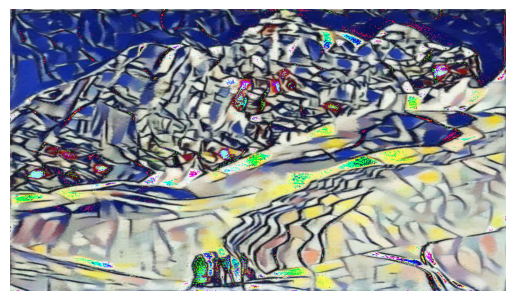

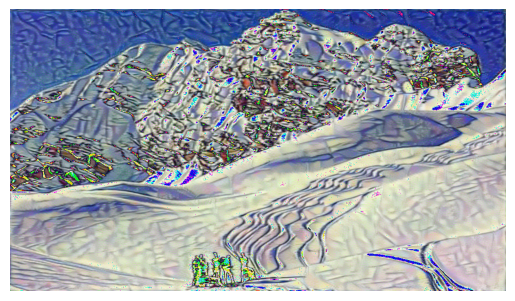

In [ ]:
content_image = load_image('content/mountains.jpg')
style_image = load_image('styles/the-exit-of-the-russian-ballet.jpg')

content_size = (content_image.size(2), content_image.size(3))  # (H, W)
style_image = F.interpolate(
    style_image,
    size=content_size,
    mode='bilinear',
    align_corners=False,
    antialias=True  )
output_image_adam = run_style_transfer_adam(
    content_image,
    style_image,
    num_steps=50,
    content_weight=1,
    style_weight=1e4  
)

output_image_LBFGS = run_style_transfer(
    content_image,
    style_image,
    num_steps=50,
    content_weight=1,
    style_weight=1e4  
)
def postprocess_image(tensor):
    tensor = tensor.cpu().clone().squeeze(0)
    transform = transforms.Compose([
        transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225], std=[1/0.229, 1/0.224, 1/0.225]),
        transforms.ToPILImage()
    ])
    return transform(tensor)

output_image_adam = postprocess_image(output_image_adam)
output_image_LBFGS = postprocess_image(output_image_LBFGS)
plt.imshow(output_image_LBFGS)
plt.axis('off')
plt.show()
plt.imshow(output_image_adam)
plt.axis('off')
plt.show()


from the looks of it , LBFGS applies style more aggresively as compared to Adams optimiser , reason being it does line searches and thus making larger updates when compared to adam optimiser making momentum based changes which function to stablise the loss thereby discouraging any strong-style transfers.

I would think that paintings with a very strong sense of texture and strokes (like the one i used) will transfer styles over very easily when compared to minimalistic or abstract arts like the "bet-you" painting ( I tried it and it didnt look good) , also photos with very complex features might lose a lot of content in style transferring and thereby looking really distorted and not satisfying.